<a href="https://colab.research.google.com/github/nwon24/nlp/blob/main/W8/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model performance metrics

In this notebook we will compare the baseline models, the CNN, the LSTM (with and without pretrained embeddings), and the transformer model on the same text classification task, evaluating each model on metrics such as accuracy and F1 score. The corpus will be 50000 Amazon reviews, categorised as either positive or negative reviews. These reviews will be split 80/20 for training and testing.

# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device=torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

# Hyperparameters

The same hyperparameters will be used for all the neural network models. However, depending on computing resource constraints, the transformer may not be able to run for the same number of epochs as the other models.

In [3]:
corpus_file="xaa"

test_size=0.2
batch_size=50
epochs=5
lr=5e-4

data=pd.read_csv(corpus_file)

# Baseline classifiers

## Preparing the data

In [4]:
tfidf =TfidfVectorizer()
tfidf.fit(data["text"])
trainX,testX,trainY,testY=model_selection.train_test_split(data["text"],data["label"],test_size=test_size)
Encoder=LabelEncoder()
trainY=Encoder.fit_transform(trainY)
testY=Encoder.fit_transform(testY)

trainX=tfidf.transform(trainX)
testX=tfidf.transform(testX)

## SVM

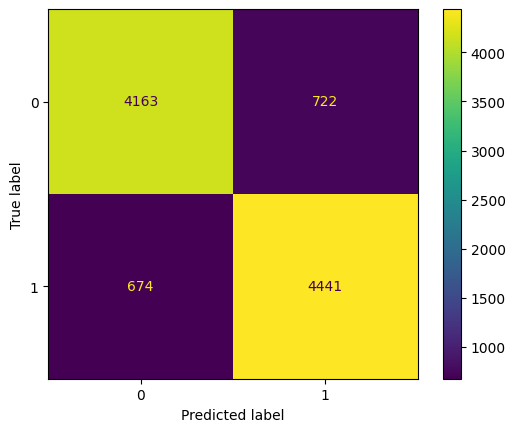

SVM accuracy: 0.8604
SVM f1: 0.8641759097100603


In [ ]:
SVM=svm.SVC(C=1.0,kernel="linear",degree=3,gamma="auto")
SVM.fit(trainX,trainY)
SVM_pred=SVM.predict(testX)
SVM_accuracy=accuracy_score(testY,SVM_pred)
SVM_f1=f1_score(testY,SVM_pred)
ConfusionMatrixDisplay.from_predictions(testY,SVM_pred)
plt.show()
print(f"SVM accuracy: {SVM_accuracy}")
print(f"SVM f1: {SVM_f1}")

## Logistic regression

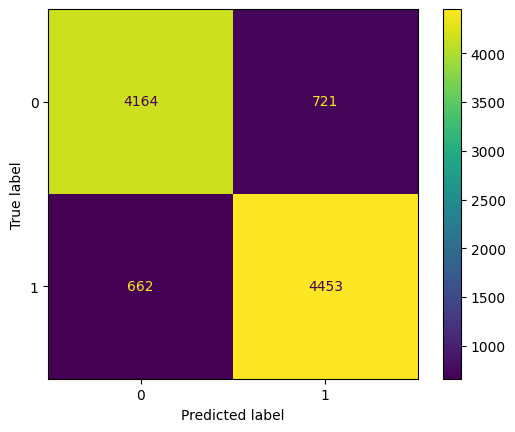

LR accuracy: 0.8617
LR f1: 0.8655846049178735


In [ ]:
LR=LogisticRegression()
LR.fit(trainX,trainY)
LR_pred=LR.predict(testX)
LR_accuracy=accuracy_score(testY,LR_pred)
LR_f1=f1_score(testY,LR_pred)
ConfusionMatrixDisplay.from_predictions(testY,LR_pred)
plt.show()
print(f"LR accuracy: {LR_accuracy}")
print(f"LR f1: {LR_f1}")

# Generic class for models

This will make training and testing a range of models with the same hyperperamaters and datasets easier. The `reshape` method is required because different models have different input shapes, and therefore the child class can simply override this method found in the parent class.

In [5]:
class Model():
    def __init__(self,model,loss_fn,optimizer,train_loader,test_loader,batch_size,epochs):
        self.model=model.to(device)
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.train_loader=train_loader
        self.test_loader=test_loader
        self.batch_size=batch_size
        self.epochs=epochs

    def reshape(self,x):
        return x

    def train(self):
        self.model.train()
        size=len(self.train_loader.dataset)
        for epoch in range(self.epochs):
            for batch,(x,y) in enumerate(self.train_loader):
                x,y=x.to(device),y.to(device)
                pred=self.model(self.reshape(x))
                cost=self.loss_fn(pred.flatten(),y)
                cost.backward()
                self.optimizer.step()
                self.optimizer.zero_grad()
                if batch%10 == 0:
                    cost,current=cost.item(),batch*self.batch_size+len(x)
                    print(f"Epoch {epoch}, cost: {cost:>7f}  [{current:>5d}/{size:>5d}]")

    def test_loop(self):
        size=len(self.test_loader.dataset)
        num_batches=len(self.test_loader)
        correct=0

        preds=[]
        with torch.no_grad():
            for (x,y) in self.test_loader:
                x,y=x.to(device),y.to(device)
                pred=self.model(self.reshape(x)).flatten()
                preds.append(pred)
                ncorrect=(torch.round(pred) == y).sum().item()
                correct+=ncorrect

        #print(correct,size)
        #print(f"Test Error: \n Accuracy: {(100*correct/size):>0.1f}%, Avg loss: {100*test_loss/size:>8f} \n")
        return 100*correct/size,np.hstack(preds)

    def test(self):
        self.model.eval()
        x=np.arange(self.epochs)
        y=np.zeros(self.epochs)
        preds=np.zeros((self.epochs,len(self.test_loader.dataset)))
        for epoch in range(self.epochs):
            y[epoch],preds[epoch]=self.test_loop()
        plt.plot(x,y)
        plt.xlabel("epoch")
        plt.ylabel("Accuracy")
        plt.title("Accuracy vs epoch")
        i=np.argmax(y)
        print(f"Maximum accuracy (epoch {i+1}) = {y[i]:.4f}")
        f1=f1_score(self.test_loader.dataset.getlabel(),np.round(preds[i]))
        print(f"F1 score = {f1}")
        ConfusionMatrixDisplay.from_predictions(self.test_loader.dataset.getlabel(),np.round(preds[i]))
        plt.show()

In [6]:
class corpus(Dataset):
    def __init__(self,corpus,label):
        self.corpus=corpus
        self.label=label
    def __len__(self):
        return len(self.corpus)
    def __getitem__(self,idx):
        return self.corpus[idx],self.label[idx]
    def getlabel(self):
        return self.label

# CNN

In [7]:
class CNNClassifier(nn.Module):
    def __init__(self,n,kerns,pool_kerns,out_chans):
        super(CNNClassifier,self).__init__()
        self.kerns=kerns
        self.pool_kerns=pool_kerns
        self.convs=[]
        self.pools=[]
        self.stride=1
        self.n=n
        #self.embed=nn.Embedding(n,max_length)
        in_chan=1
        for i in range(len(kerns)):
            out_chan=out_chans[i]
            kern=kerns[i]
            pool_kern=pool_kerns[i]
            self.convs.append(nn.Conv1d(in_chan,out_chan,kern))
            self.compute_size(kern,self.stride)
            self.pools.append(nn.MaxPool1d(pool_kern))
            self.compute_size(pool_kern,pool_kern)
            in_chan=out_chan
        self.convs=nn.ModuleList(self.convs)
        self.pools=nn.ModuleList(self.pools)
        self.fc1=nn.Linear(self.n*out_chan,1)
        #self.fc2=nn.Linear(100,1)

    def compute_size(self,kernel,stride):
        self.n=(self.n-kernel)//stride+1
        return self.n

    def forward(self,x):
        #x=self.embed(x)
        for i in range(len(self.kerns)):
            x=nn.LeakyReLU()(self.convs[i](x))
            x=self.pools[i](x)
            x=nn.Dropout(0.2)(x)
        x=torch.flatten(x,1)
        #x=F.relu(self.fc1(x))
        #x=self.fc2(x)
        x=self.fc1(x)
        x=nn.Sigmoid()(x)
        return x

class CNNModel(Model):
    def reshape(self,x):
        return x.reshape(self.batch_size,1,x.shape[1])

In [8]:
trainX=torch.from_numpy(trainX.toarray()).float()
testX=torch.from_numpy(testX.toarray()).float()
trainY=torch.from_numpy(trainY).float()
testY=torch.from_numpy(testY).float()

In [9]:
train_loader=DataLoader(corpus(trainX,trainY),batch_size=batch_size)
test_loader=DataLoader(corpus(testX,testY),batch_size=batch_size)
cnn_classifier=CNNClassifier(trainX.shape[1],[2],[2],[3])
cnn=CNNModel(cnn_classifier,nn.BCELoss(),Adam(cnn_classifier.parameters(),lr=lr),train_loader,test_loader,batch_size,epochs)

Epoch 0, cost: 0.700220  [   50/24000]
Epoch 0, cost: 2.766129  [  550/24000]
Epoch 0, cost: 0.866155  [ 1050/24000]
Epoch 0, cost: 0.691168  [ 1550/24000]
Epoch 0, cost: 0.693895  [ 2050/24000]
Epoch 0, cost: 0.683957  [ 2550/24000]
Epoch 0, cost: 0.749100  [ 3050/24000]
Epoch 0, cost: 0.643829  [ 3550/24000]
Epoch 0, cost: 0.707815  [ 4050/24000]
Epoch 0, cost: 0.946185  [ 4550/24000]
Epoch 0, cost: 0.910783  [ 5050/24000]
Epoch 0, cost: 0.719093  [ 5550/24000]
Epoch 0, cost: 0.693036  [ 6050/24000]
Epoch 0, cost: 0.726782  [ 6550/24000]
Epoch 0, cost: 0.703042  [ 7050/24000]
Epoch 0, cost: 0.684406  [ 7550/24000]
Epoch 0, cost: 0.674826  [ 8050/24000]
Epoch 0, cost: 0.762691  [ 8550/24000]
Epoch 0, cost: 0.715914  [ 9050/24000]
Epoch 0, cost: 0.624152  [ 9550/24000]
Epoch 0, cost: 0.821705  [10050/24000]
Epoch 0, cost: 0.693825  [10550/24000]
Epoch 0, cost: 0.723762  [11050/24000]
Epoch 0, cost: 0.687395  [11550/24000]
Epoch 0, cost: 0.681269  [12050/24000]
Epoch 0, cost: 0.710215  

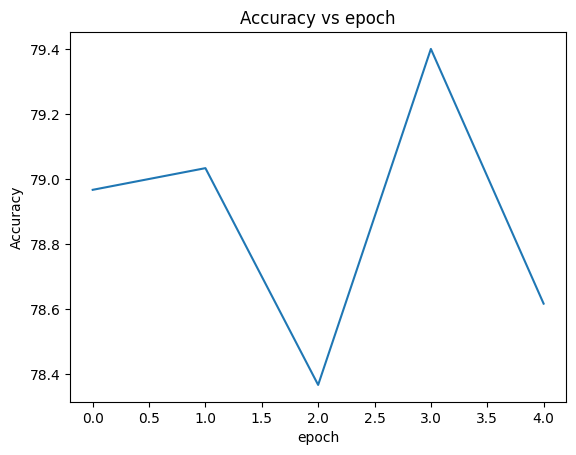

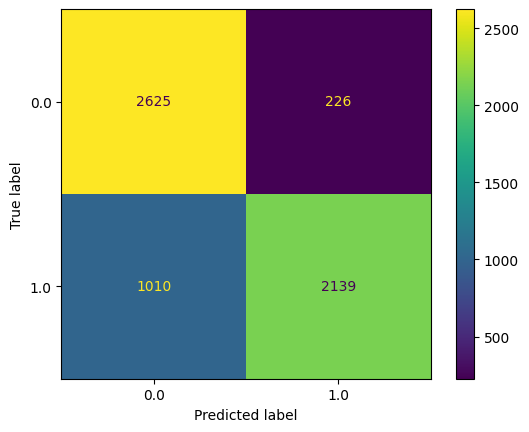

In [10]:
cnn.train()
cnn.test()


# LSTM